# Study on Yelp-Hat

Paper: https://davis.wpi.edu/dsrg/PROJECTS/YELPHAT/2020_ACL_Human_vs_Machine-2.pdf

Summary:
* __Do annotators carefully choose relevant words?__ Yes, as the collecting time and number of chosen words increase accross the sentence length.

Sigles:
* __HAM__ (Human Attention Map): what annotators denote
* __CAM__ (Consensus Attention Map): bitwise __AND__ operation of the HAMs
* __SAM__ (Super Attention Map): bitwise __OR__ operation of the HAMs. 


In [1]:
%load_ext autoreload
%autoreload 2

from IPython.display import display, HTML
import os
from os import path

import sys
sys.path.append("./../src")

cache_path = path.join(os.getcwd(), '..', '.cache')

DATASET_NAME='yelp-hat'

dataset_path = path.join(cache_path, 'dataset', DATASET_NAME)

tmp_path = path.join('.cache', '2022-07-29')
os.makedirs(tmp_path,exist_ok=True)

Download and extract dataset

In [2]:
from torchtext.utils import download_from_url, extract_archive
import shutil

# Download dataset zip
URL='https://github.com/cansusen/Human-Attention-for-Text-Classification/archive/205c1552bc7be7ec48623d79d85d4c6fbfe62362.zip'

zip_path = download_from_url(URL, root=dataset_path, path=path.join(dataset_path, f'{DATASET_NAME}.zip'))
extracted_path = path.join(dataset_path, 'caching')
files = extract_archive(from_path=zip_path, to_path=extracted_path)
files = [f for f in files if f.endswith('.csv')]

for f in files: shutil.copy2(f, extracted_path)

A quoi ressemble la dataset?

In [3]:
import pandas as pd

df = pd.read_csv(path.join(extracted_path, 'ham_part1(50words).csv'))
df

,Input.label,Input.text,Answer.Q1Answer,Answer.html_output
0,1,Out in Twinsburg for work and wasn't expecting...,yes,<span>Out</span> <span>in</span> <span>Twinsbu...
1,1,Out in Twinsburg for work and wasn't expecting...,yes,<span>Out</span> <span>in</span> <span>Twinsbu...
2,1,Out in Twinsburg for work and wasn't expecting...,yes,<span>Out</span> <span>in</span> <span>Twinsbu...
3,0,Very slow. Never been in the drive at any othe...,no,"<span class=""active"">Very</span> <span class=""..."
4,0,Very slow. Never been in the drive at any othe...,no,"<span>Very</span> <span class=""active"">slow.</..."
...,...,...,...,...
895,0,I went here to get a snack before I went on th...,no,<span>I</span> <span>went</span> <span>here</s...
896,0,I went here to get a snack before I went on th...,no,<span>I</span> <span>went</span> <span>here</s...
897,0,Always packed for lunch. Probably because Pit...,no,<span>Always</span> <span>packed</span> <span>...
898,0,Always packed for lunch. Probably because Pit...,no,<span>Always</span> <span>packed</span> <span>...


In [4]:
import re
def generate_binary_human_attention_vector(html, num_words_in_review, max_words):
    # Function provided by the dataset :
    # https://github.com/cansusen/Human-Attention-for-Text-Classification/blob/master/generate_ham/sample_generate.ipynb

    p = re.compile('<span(.*?)/span>')
    all_span_items = p.findall(html)

    if html == '{}':
        print('Empty human annotation - This should never print')
        return [0] * max_words

    if len(all_span_items) == num_words_in_review + 1:
        if (all_span_items[num_words_in_review] == '><') or (all_span_items[num_words_in_review] == ' data-vivaldi-spatnav-clickable="1"><'):

            binarized_human_attention = [0] * max_words
            for i in range(0, len(all_span_items) - 1):
                if 'class="active"' in all_span_items[i]:
                    binarized_human_attention[i] = 1

        else:
            print('This should never print.')
    else:
        print('This should never print.')

    return binarized_human_attention

MAX_WORDS = 100
i = 0
html = df['Answer.html_output'][i]
num_highlighted = html.count('class="active"')
num_words_in_review = len(df['Input.text'][i].split())

binarized_human_attention = generate_binary_human_attention_vector(html, num_words_in_review, MAX_WORDS)


print("Number of words highlighted in this review:",num_highlighted)
print("Original annotation:", html)
print("Binarized attention map:",binarized_human_attention)

Number of words highlighted in this review: 6
Original annotation: <span>Out</span> <span>in</span> <span>Twinsburg</span> <span>for</span> <span>work</span> <span>and</span> <span>wasn't</span> <span>expecting</span> <span>to</span> <span>find</span> <span>a</span> <span>well</span> <span>reviewed</span> <span>sushi</span> <span>restaurant</span> <span>but</span> <span class="active">glad</span> <span>I</span> <span>did.</span> <span>It</span> <span>was</span> <span>quite</span> <span>busy</span> <span>for</span> <span>a</span> <span>Monday</span> <span>and</span> <span>the</span> <span>poor</span> <span>waitress</span> <span>was</span> <span>slammed</span> <span>but</span> <span>the</span> <span>sushi</span> <span>chef</span> <span>stepped</span> <span>in</span> <span>to</span> <span>help</span> <span>and</span> <span>was</span> <span class="active">very</span> <span class="active">friendly.</span> <span>The</span> <span class="active">presentation</span> <span>and</span> <span class

In [6]:
def tokenize(html):
    p = re.compile(r'<span[^>]*>(.+?)</span>')
    return p.findall(html)

def human_attention(html):

    p = re.compile('<span(.*?)/span>')
    all_span_items = p.findall(html)
    if all_span_items[-1] == '><': all_span_items = all_span_items[:-1]

    return ['class="active"' in span_item for span_item in all_span_items]

v_hat = human_attention(html)
print(v_hat)

# Check if we tokenize html, can our function "human_attention" reproduce the exact same length
for fpath in os.listdir(dataset_path):
    
    if fpath.endswith('.csv'):
        print('Check',fpath)
        df = pd.read_csv(path.join(dataset_path, fpath))
        print(len(df['Answer.html_output']))
        for html in df['Answer.html_output']:
            tokens = tokenize(html)
            v_hat = human_attention(html)
            if len(tokens) != len(v_hat):
                print(len(tokens), len(v_hat))
                print(' '.tokens)
                display(HTML(html))

[False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, True, False, True, False, True, False, True]


Proceed dataset step by step

In [8]:
from data.yelp_hat.utils import yelp_hat_ham, yelp_hat_token
import numpy as np
import spacy

nlp = spacy.load('en_core_web_sm')

df = pd.read_csv(path.join(extracted_path, 'ham_part5.csv'))
display(HTML('<h3>Raw dataset</h3>'))
display(df.head())

dupli_2 = duplicates[duplicates['size'] == 2]  # finds dupli_2
df = df[~df['Input.text'].isin(dupli_2['index'])]

df['ham_'] = df[f'Answer.html_output'].apply(lambda x: yelp_hat_ham(x, nlp)).apply(lambda x: np.array(x))
df['text_tokens'] = df['Answer.html_output'].apply(lambda x: yelp_hat_token(x, nlp))
df = df.rename(columns={'Answer.Q1Answer': 'human_label_', 'Input.text': 'text', 'Input.label': 'label'})

display(HTML('<h3>Preprocess text and human attention</h3>'))
display(df.head())

dfs = [df.loc[0::3, ['text', 'label', 'text_tokens']].reset_index(drop=True)]
for idx in range(3):
    _data = df.loc[idx::3, ['ham_', 'human_label_']]
    _data = _data.reset_index(drop=True).add_suffix(str(idx))
    dfs += [_data]
    
df = pd.concat(dfs, axis=1)

def cam(row):
    return np.logical_and(row['ham_0'],row['ham_1'],row['ham_2'])

def sam(row):
    return np.logical_or(row['ham_0'],row['ham_1'],row['ham_2'])

def ham(row):
    return ((row['ham_0'] + row['ham_1'] + row['ham_2'])/3 >= 0.5).astype(int)

df['cam'] = df.apply(cam,axis=1)
df['sam'] = df.apply(sam,axis=1)
df['ham'] = df.apply(ham,axis=1)

df.head()

,Input.label,Input.text,Answer.Q1Answer,Answer.html_output
0,0,"I don't think so. \n\nThis ""buffet"" is probabl...",no,<span>I</span> <span>don't</span> <span>think<...
1,0,"I don't think so. \n\nThis ""buffet"" is probabl...",no,"<span>I</span> <span class=""active"">don't</spa..."
2,0,"I don't think so. \n\nThis ""buffet"" is probabl...",no,<span>I</span> <span>don't</span> <span>think<...
3,1,Ate here two times now and food has been excel...,yes,<span>Ate</span> <span>here</span> <span>two</...
4,1,Ate here two times now and food has been excel...,yes,<span>Ate</span> <span>here</span> <span>two</...


NameError: name 'duplicates' is not defined

In [ ]:
df = pd.read_csv(path.join(extracted_path, 'ham_part5.csv'))
duplicates = df.groupby(df['Input.text'].tolist(),as_index=False).size()
display(duplicates['size'].unique())
for dup_rows in [2, 3]:
    print('Duplicate of', dup_rows, ':', sum(duplicate['size'] == dup_rows))
    
dupli_2 = duplicates[duplicates['size'] == 2]  # finds dupli_2
df = df[~df['Input.text'].isin(dupli_2['index'])]
duplicate = df.groupby(df['Input.text'].tolist(),as_index=False).size()
display(duplicate['size'].unique())

In [ ]:
df['coherent_ham_01'] = df['ham_0'].str.len() == df['ham_1'].str.len()
df['coherent_ham_12'] = df['ham_1'].str.len() == df['ham_2'].str.len()
print(df['coherent_ham_01'].all())
print(df['coherent_ham_12'].all())
print('#Incoherent length:', df['coherent_ham_12'].sum())

In [ ]:
def cam(row):
    return np.logical_and(row['ham_0'],row['ham_1'],row['ham_2'])

def sam(row):
    return np.logical_or(row['ham_0'],row['ham_1'],row['ham_2'])

def ham(row):
    return ((row['ham_0'] + row['ham_1'] + row['ham_2'])/3 >= 0.5).astype(int)

for f in files:
    print(f)
    df = pd.read_csv(f)
    df['ham_'] = df[f'Answer.html_output'].apply(yelp_hat_ham).apply(lambda x: np.array(x))
    df['text_tokens'] = df['Answer.html_output'].apply(yelp_hat_token)
    df = df.rename(columns={'Answer.Q1Answer': 'human_label_', 'Input.text': 'text', 'Input.label': 'label'})
    dfs = [df.loc[0::3, ['text', 'label', 'text_tokens']].reset_index(drop=True)]
    for idx in range(3):
        _data = df.loc[idx::3, ['ham_', 'human_label_']]
        _data = _data.reset_index(drop=True).add_suffix(str(idx))
        dfs += [_data]

    df = pd.concat(dfs, axis=1)

    try:
        df['cam'] = df.apply(cam,axis=1)
        df['sam'] = df.apply(sam,axis=1)
        df['ham'] = df.apply(ham,axis=1)
    except ValueError as e:
        print(e)
        continue

In [ ]:
import numpy as np

def cam(row):
    return np.logical_and(row['ham_0'],row['ham_1'],row['ham_2'])

def sam(row):
    return np.logical_or(row['ham_0'],row['ham_1'],row['ham_2'])

def ham(row):
    return ((row['ham_0'] + row['ham_1'] + row['ham_2'])/3 >= 0.5).astype(int)

df['cam'] = df.apply(cam,axis=1)
df['sam'] = df.apply(sam,axis=1)
df['ham'] = df.apply(ham,axis=1)
df.head()
# sam = df.apply(lambda x: np.logical_and(np.array(x['ham_0']), np.array(x['ham_1']), np.array(x['ham_2'])))

<div class="alert alert-block alert-info">
    <b>Note:</b> By reconcatenating for spacy and re tokenize, do we obtain the coherent length?
</div>    

In [134]:
from tqdm.notebook import tqdm
from bs4 import BeautifulSoup
import spacy 

nlp = spacy.load('en_core_web_sm')
# soup = BeautifulSoup(html, 'html.parser')

def tokenize_ham(html):
    soup = BeautifulSoup(html, 'html.parser')
    tags = [str(tag.string) for tag in soup.find_all('span') if tag.string is not None]
    tokens = [str(tk.text) for doc in nlp.pipe(tags) for tk in doc]
    return tokens

files = [fpath for fpath in os.listdir(extracted_path) if fpath.endswith('.csv') and 'part7' not in fpath]

for fpath in tqdm(files, total=len(files)):
        
    df = pd.read_csv(path.join(extracted_path, fpath))

    dfs = [df.loc[0::3, df.columns != 'Answer.html_output'].reset_index(drop=True)]
    dfs += [df.loc[idx::3, ['Answer.html_output']].reset_index(drop=True).rename(columns={'Answer.html_output':'ham_html_'}).add_suffix(str(idx)) for idx in range(3) ]
    clean_df = pd.concat(dfs,axis=1).rename(columns={'Input.label': 'label', 'Input.text': 'text', 'Answer.Q1Answer':'human_label'})
    clean_df = clean_df[['text', 'ham_html_0', 'ham_html_1', 'ham_html_2', 'label', 'human_label']]

    clean_df['ham_tokens'] = clean_df['ham_html_0'].apply(tokenize_ham)
    clean_df['count_ham_tokens'] = clean_df['ham_tokens'].apply(lambda row: len(row))

    clean_df['text_tokens'] = [[tk.text for tk in doc if not tk.is_space] for doc in nlp.pipe(clean_df['text'].tolist())]
    clean_df['count_text_tokens'] = clean_df['text_tokens'].apply(lambda row: len(row))

    is_every_row_ok = (clean_df['count_text_tokens'] == clean_df['count_ham_tokens']).all()
    print(fpath, ': Same tokens between text and ham >', is_every_row_ok)

  0%|          | 0/6 [00:00<?, ?it/s]

ham_part5.csv : Same tokens between text and ham > True
ham_part8(200words).csv : Same tokens between text and ham > True
ham_part6(100words).csv : Same tokens between text and ham > True
ham_part4.csv : Same tokens between text and ham > True
ham_part3.csv : Same tokens between text and ham > True
ham_part1(50words).csv : Same tokens between text and ham > True


###### Split tokens in human attention maps by spacy, verify if `len(token) == len(annotation)`

In [ ]:
def binarize_ham(html):
    soup = BeautifulSoup(html, 'html.parser')
    tags = [tag for tag in soup.find_all('span') if tag.string is not None]
    
    tag_annot = [int('active' in t.get('class', [])) for t in tags]
    tag_str = [str(t.string) for t in tags]
    
    ham = []
    
    for annot, splitted_tokens in zip(tag_annot, nlp.pipe(tag_str)):
        annotation = [annot * int(not tk.is_punct) for tk in splitted_tokens]
        ham += annotation
    
    return ham

html = clean_df['ham_html_0']
print(html[0])
print(tokenize_ham(html[0]))

In [ ]:
files = [fpath for fpath in os.listdir(dataset_path) if fpath.endswith('.csv') and 'part7' not in fpath]

for fpath in tqdm(files, total=len(files)):
        
    df = pd.read_csv(path.join(dataset_path, fpath))

    dfs = [df.loc[0::3, df.columns != 'Answer.html_output'].reset_index(drop=True)]
    dfs += [df.loc[idx::3, ['Answer.html_output']].reset_index(drop=True).rename(columns={'Answer.html_output':'annotation_html_'}).add_suffix(str(idx)) for idx in range(3) ]
    clean_df = pd.concat(dfs,axis=1).rename(columns={'Input.label': 'label', 'Input.text': 'text', 'Answer.Q1Answer':'human_label'})
    clean_df = clean_df[['text', 'ham_html_0', 'ham_html_1', 'ham_html_2', 'label', 'human_label']]

    clean_df['ham_tokens'] = clean_df['ham_html_0'].apply(binarize_ham)
    clean_df['count_ham_tokens'] = clean_df['ham_tokens'].apply(lambda row: len(row))

    clean_df['text_tokens'] = [[tk.text for tk in doc if not tk.is_space] for doc in nlp.pipe(clean_df['text'].tolist())]
    clean_df['count_text_tokens'] = clean_df['text_tokens'].apply(lambda row: len(row))

    is_every_row_ok = (clean_df['count_text_tokens'] == clean_df['count_ham_tokens']).all()
    print(fpath, ': Same tokens between text and ham >', is_every_row_ok)

## Check sentence length

In [30]:
for fpath in tqdm(files, total=len(files)):
        
    df = pd.read_csv(path.join(dataset_path, fpath))
    display(HTML(f'<h3>{fpath}</h3>'))
    dfs = [df.loc[0::3, df.columns != 'Answer.html_output'].reset_index(drop=True)]
    dfs += [df.loc[idx::3, ['Answer.html_output']].reset_index(drop=True).rename(columns={'Answer.html_output':'ham_html_'}).add_suffix(str(idx)) for idx in range(3) ]
    clean_df = pd.concat(dfs,axis=1).rename(columns={'Input.label': 'label', 'Input.text': 'text', 'Answer.Q1Answer':'human_label'})
    clean_df = clean_df[['text', 'ham_html_0', 'ham_html_1', 'ham_html_2', 'label', 'human_label']]
    clean_df['text_tokens'] = [[tk.text for tk in doc if not tk.is_space] for doc in nlp.pipe(clean_df['text'].tolist())]
    
    clean_df['text_length'] = clean_df.text_tokens.str.len()
    display(clean_df.describe().transpose())

  0%|          | 0/6 [00:00<?, ?it/s]

,count,mean,std,min,25%,50%,75%,max
label,1000.0,0.516,0.499994,0.0,0.0,1.0,1.0,1.0
text_length,1000.0,71.694,7.983865,55.0,66.0,71.0,78.0,97.0


,count,mean,std,min,25%,50%,75%,max
label,181.0,0.508287,0.501318,0.0,0.0,1.0,1.0,1.0
text_length,181.0,230.071823,8.317340,210.0,224.0,230.0,235.0,252.0


,count,mean,std,min,25%,50%,75%,max
label,438.0,0.513699,0.500384,0.0,0.0,1.0,1.0,1.0
text_length,438.0,115.276256,5.565827,101.0,112.0,114.0,118.0,144.0


,count,mean,std,min,25%,50%,75%,max
label,1000.0,0.507,0.500201,0.0,0.0,1.0,1.0,1.0
text_length,1000.0,71.604,7.837641,55.0,65.0,71.0,78.0,101.0


,count,mean,std,min,25%,50%,75%,max
label,1000.0,0.497,0.500241,0.0,0.0,0.0,1.0,1.0
text_length,1000.0,71.958,8.178944,53.0,65.0,72.0,78.0,107.0


,count,mean,std,min,25%,50%,75%,max
label,300.0,0.483333,0.500557,0.0,0.0,0.0,1.0,1.0
text_length,300.0,58.006667,3.009454,50.0,56.0,57.0,60.0,72.0


## Test dataset

In [7]:
from data_module.yelp_hat_module import YelpHatDM
dm = YelpHatDM(cache_path=path.join(cache_path, 'dataset'), batch_size=4)

In [8]:
dm.prepare_data()
dm.setup()
dataloader = dm.train_dataloader()

In [10]:
dm.train_set.data.loc[:4, 'text'].tolist()

["4.5 Stars but giving 5 as I'd like to see this business to stay. This particular location of this strip mall has had businesses come and go too often too much. This Los Taquitos offers fresh yummy food with very reasonable price. The decor is cute and it is clean. We (4 of us) all loved our street tacos. Everything tasted fresh and clean.",
 "Ordered food through GrubHub on a particularly-cold day and it arrived hot delicious! Ordered a bowl--pierogies are out-of-this-world and the tofu had a bit of a spice to it. Grilled veggies were nice. Never been to Harris Grill even though I'm in their 'hood but will def frequent it from now on!",
 'If you know of a place with fried chicken that\'s not greasy but full of flavor, please let me know. I mean, if you are looking for healthy, you don\'t start looking at something that starts with the word "FRIED". I found this chicken tasty, but not dripping with fat. Better than KFC by far.',
 "So this place reminds me of this lil mom and pop place

## Statistics

In [12]:
dm.train_set.data['text_length'] = dm.train_set.data.text_tokens.str.len()

In [13]:
dm.train_set.data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
label,12.0,0.500000,0.522233,0.0,0.00,0.5,1.0,1.0
text_length,12.0,71.166667,6.293335,63.0,67.75,69.5,73.5,87.0


## Choice for vocabulary

In [27]:
from tqdm.notebook import tqdm
import sys
import spacy
from torchtext.vocab import build_vocab_from_iterator

# Original
print('Length vocab in original form:',len(dm.vocab))

# Lower
PAD_TOK = '<pad>'
UNK_TOK = '<unk>'

dp = dm.train_set.batch(8).map(lambda batch: {k: [row[k] for row in batch] for k in batch[0]}).map(lambda batch: [token.lower() for sentence in batch['text_tokens'] for token in sentence])
iter_tokens = tqdm(iter(dp), desc='Building vocabulary', total=len(dp), unit='sents', file=sys.stdout)
lower_vocab = build_vocab_from_iterator(iterator=iter_tokens, specials=[PAD_TOK, UNK_TOK])

print('Length for lower vocab:',len(lower_vocab))

# Lower lemma
nlp = spacy.load('en_core_web_sm')
tokens = [tk for doc in dm.train_set.data['text_tokens'] for tk in doc]
doc = spacy.tokens.Doc(nlp.vocab, words=tokens)
lemmatized = [tk.lemma_ for tk in nlp(doc)]
lemma_vocab = build_vocab_from_iterator(iterator=lemmatized, specials=[PAD_TOK, UNK_TOK])
print('Length for lower lemma vocab:',len(lemma_vocab))

Length vocab in original form: 1018


Building vocabulary:   0%|          | 0/8 [00:00<?, ?sents/s]

Length for lower vocab: 1018
Length for lower lemma vocab: 54


## Find words statistics for class prediction

yelp:   0%|          | 0/253152 [00:00<?, ?it/s]

yelp50:   0%|          | 0/17702 [00:00<?, ?it/s]

yelp100:   0%|          | 0/50788 [00:00<?, ?it/s]

yelp200:   0%|          | 0/41352 [00:00<?, ?it/s]

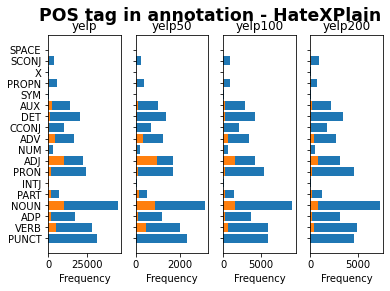

In [17]:
from data.yelp_hat.spacy_pretok_dataset import SpacyPretokenizeYelpHat
from tqdm.notebook import tqdm
import spacy
from spacy.tokens import Doc

cnt = dict()
SPLIT = ['yelp', 'yelp50', 'yelp100', 'yelp200']

spacy_model = spacy.load('en_core_web_sm')

for split in SPLIT:
    
    # Load dataset
    dataset = SpacyPretokenizeYelpHat(root=dataset_path, split=split, spacy_model=spacy_model, lemma=True, lower=True)
    tokens = dataset.data['text_tokens']
    rationale = dataset.data['ham']

    # Add punctuation to separate sentences
    for i in range(len(tokens)):
        tokens[i].append('.')
        rationale[i].append(0)

    flatten_token = [tk for sent in tokens for tk in sent]
    flatten_rationale = [r for sent in rationale for r in sent]

    nlp = spacy.load('en_core_web_sm')
    doc = Doc(nlp.vocab, words=flatten_token)
    pos = [tk.pos_ for tk in nlp(doc)]
    
    # Start counting
    cnt_pos = dict()
    cnt_tok = dict()
    cnt_pos_total = dict()
    cnt_tok_total = dict()
    
    for p, r, t in tqdm(zip(pos, flatten_rationale, flatten_token), total=len(flatten_rationale), desc=split):
    
        cnt_pos_total[p] = cnt_pos_total.get(p, 0) +1
        cnt_tok_total[t] = cnt_tok_total.get(t, 0) +1

        if r > 0:
            cnt_pos[p] = cnt_pos.get(p, 0) + 1
            cnt_tok[t] = cnt_tok.get(t, 0) + 1
            
    cnt[split] = {
        'pos' : cnt_pos,
        'tok' : cnt_tok,
        'pos_total': cnt_pos_total,
        'tok_total': cnt_tok_total
    }
    
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (10*len(SPLIT),10)

fig, axes = plt.subplots(1, len(SPLIT), sharey=True)
fig.suptitle('POS tag in annotation - Yelp HAT', fontsize='xx-large', fontweight='black')

for ax, pos_freq, split in zip(axes, cnt.values(), cnt.keys()):
    
    cnt_pos_total = pos_freq['pos_total']
    cnt_pos = pos_freq['pos']

    ax.barh(width=cnt_pos_total.values(), y=list(cnt_pos_total.keys()))
    ax.barh(width=cnt_pos.values(), y=list(cnt_pos.keys()))

    ax.invert_yaxis()

    ax.set_xlabel('Frequency')
    ax.set_title(split)

plt.savefig(path.join(tmp_path, 'posfreq_yelphat'), dpi=600)

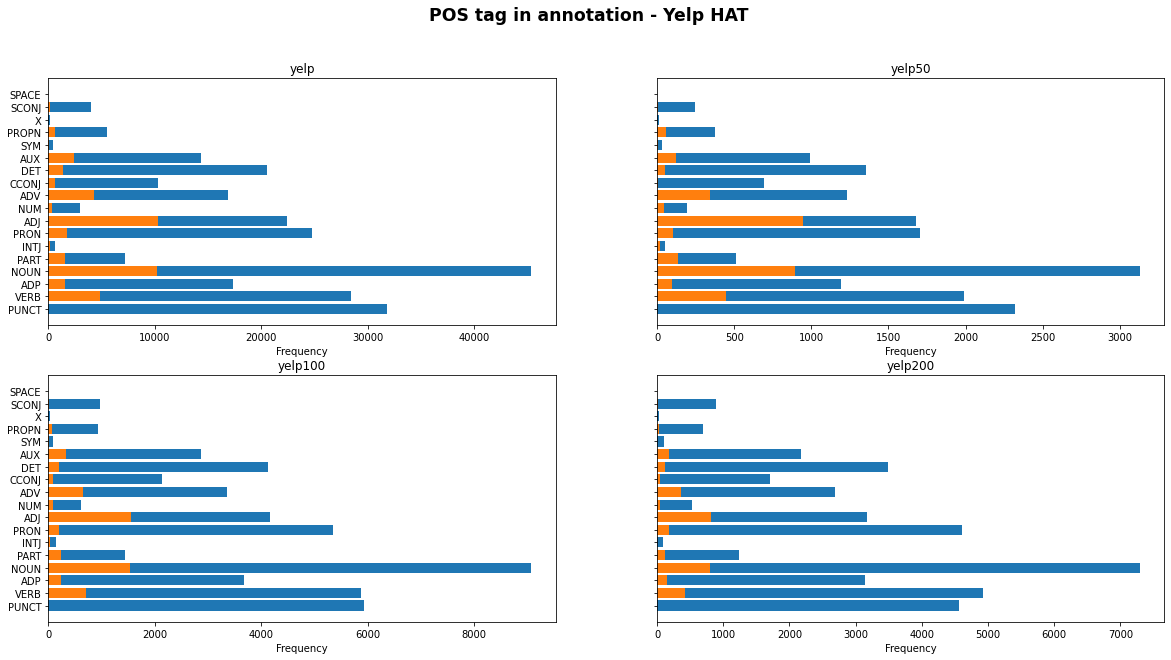

In [26]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (20,10)

fig, axes = plt.subplots(2, 2, sharey=True)
fig.suptitle('POS tag in annotation - Yelp HAT', fontsize='xx-large', fontweight='black')

for ax, pos_freq, split in zip(axes.flatten(), cnt.values(), cnt.keys()):
    
    cnt_pos_total = pos_freq['pos_total']
    cnt_pos = pos_freq['pos']

    ax.barh(width=cnt_pos_total.values(), y=list(cnt_pos_total.keys()))
    ax.barh(width=cnt_pos.values(), y=list(cnt_pos.keys()))

    ax.invert_yaxis()

    ax.set_xlabel('Frequency')
    ax.set_title(split)

plt.savefig(path.join(tmp_path, 'posfreq_yelphat'), dpi=600)

In [27]:
(cnt_pos['VERB'] + cnt_pos['NOUN'] + cnt_pos['ADJ']) / sum(cnt_pos.values())

0.6202916160388822

## Statistics on annotation

In [38]:
from data.yelp_hat.spacy_pretok_dataset import SpacyPretokenizeYelpHat
from tqdm.notebook import tqdm
import spacy
from spacy.tokens import Doc

cnt_annotation = dict()

for split in ['train', 'val', 'yelp50', 'yelp100', 'yelp200']:
    
    # Load dataset
    dataset = SpacyPretokenizeYelpHat(root=dataset_path, split=split)
    dataset.data = dataset.data[dataset.data['label'] == 1].reset_index()
    tokens_form = dataset.data['tokens.form']
    tokens_norm = dataset.data['tokens.norm']
    rationale = dataset.data['ham']

    # Add punctuation to separate sentences
    for i in range(len(tokens_form)):
        tokens_form[i].append('.')
        tokens_norm[i].append('.')
        rationale[i].append(0)

    flatten_token_form = [tk for sent in tokens_form for tk in sent]
    flatten_rationale = [r for sent in rationale for r in sent]
    flatten_token_norm = [tk for sent in tokens_norm for tk in sent]

    nlp = spacy.load('en_core_web_sm')
    doc = Doc(nlp.vocab, words=flatten_token_form)
    pos = [tk.pos_ for tk in nlp(doc)]
    
    # Start counting
    cnt_pos = dict()
    cnt_tok = dict()
    cnt_pos_total = dict()
    cnt_tok_total = dict()
    
    for p, r, t in tqdm(zip(pos, flatten_rationale, flatten_token_norm), total=len(flatten_rationale), desc=split):
    
        cnt_pos_total[p] = cnt_pos_total.get(p, 0) +1
        cnt_tok_total[t] = cnt_tok_total.get(t, 0) +1

        if r > 0:
            cnt_pos[p] = cnt_pos.get(p, 0) + 1
            cnt_tok[t] = cnt_tok.get(t, 0) + 1
            
    cnt_annotation[split] = {
        'pos' : cnt_pos,
        'tok' : cnt_tok,
        'pos_total': cnt_pos_total,
        'tok_total': cnt_tok_total
    }    
    
for split in cnt_annotation:
    print('=== Most frequent pos in', split,"===")
    _count = cnt_annotation[split]['pos']
    total = sum(_count.values())
    percentage = {k: c/total for k, c in _count.items()}
    sorted_percentage = sorted(percentage.items(), key=lambda item: -item[1])
    sorted_key = [p[0] for p in sorted_percentage]
    sorted_values = [p[1] for p in sorted_percentage]
    cumulated_percentage = {'+'.join(sorted_key[:i]): sum(sorted_values[:i]) for i in range(1, len(sorted_percentage)) }
    cumulated_percentage = {k: v for k, v in cumulated_percentage.items() if v < 0.8}
    display(cumulated_percentage)
    print()

for split in cnt_annotation:
    print('=== Most 10 frequently highlighted tokens in', split,"===")
    _count = cnt_annotation[split]['tok']
    total = sum(_count.values())
    percentage = {k: c/total for k, c in _count.items()}
    sorted_percentage = sorted(percentage.items(), key=lambda item: -item[1])
    display(sorted_percentage[:10])
    print()

train:   0%|          | 0/88309 [00:00<?, ?it/s]

val:   0%|          | 0/39742 [00:00<?, ?it/s]

yelp50:   0%|          | 0/8581 [00:00<?, ?it/s]

yelp100:   0%|          | 0/26083 [00:00<?, ?it/s]

yelp200:   0%|          | 0/21180 [00:00<?, ?it/s]

=== Most frequent pos in train ===


{'ADJ': 0.3074369658874214,
 'ADJ+NOUN': 0.5589377780916731,
 'ADJ+NOUN+ADV': 0.6621936577441909,
 'ADJ+NOUN+ADV+VERB': 0.7623419733031993}


=== Most frequent pos in val ===


{'ADJ': 0.31243862520458265,
 'ADJ+NOUN': 0.558265139116203,
 'ADJ+NOUN+ADV': 0.6574468085106384,
 'ADJ+NOUN+ADV+VERB': 0.7561374795417349}


=== Most frequent pos in yelp50 ===


{'ADJ': 0.33996270975761345,
 'ADJ+NOUN': 0.6277190801740211,
 'ADJ+NOUN+VERB': 0.7501553760099441}


=== Most frequent pos in yelp100 ===


{'ADJ': 0.32138024357239514,
 'ADJ+NOUN': 0.5696887686062246,
 'ADJ+NOUN+ADV': 0.6786197564276049,
 'ADJ+NOUN+ADV+VERB': 0.7838294993234101}


=== Most frequent pos in yelp200 ===


{'ADJ': 0.3504335260115607,
 'ADJ+NOUN': 0.5671965317919075,
 'ADJ+NOUN+VERB': 0.684971098265896}


=== Most 10 frequently highlighted tokens in train ===


[('be', 0.049085387386114836),
 ('great', 0.04265837982908398),
 ('good', 0.03460696376862773),
 ('food', 0.02846246203827954),
 ('service', 0.0194929020411046),
 ('place', 0.017939119994349884),
 ('well', 0.01751536125432587),
 ('love', 0.01638533794759517),
 ('and', 0.01624408503425383),
 ('very', 0.016032205664241825)]


=== Most 10 frequently highlighted tokens in val ===


[('be', 0.05122749590834697),
 ('great', 0.0453355155482815),
 ('good', 0.03289689034369885),
 ('food', 0.02553191489361702),
 ('service', 0.02078559738134206),
 ('very', 0.018985270049099837),
 ('and', 0.01734860883797054),
 ('delicious', 0.01718494271685761),
 ('well', 0.01669394435351882),
 ('the', 0.016530278232405892)]


=== Most 10 frequently highlighted tokens in yelp50 ===


[('great', 0.05034182722187694),
 ('good', 0.044126786824114354),
 ('food', 0.03356121814791796),
 ('love', 0.027346177750155375),
 ('service', 0.019888129272840272),
 ('place', 0.019266625233064015),
 ('delicious', 0.019266625233064015),
 ('well', 0.018645121193287758),
 ('friendly', 0.01678060907395898),
 ('very', 0.016159105034182723)]


=== Most 10 frequently highlighted tokens in yelp100 ===


[('good', 0.04194857916102842),
 ('be', 0.04194857916102842),
 ('great', 0.037889039242219216),
 ('well', 0.02401894451962111),
 ('food', 0.018606224627875506),
 ('love', 0.018267929634641408),
 ('delicious', 0.017591339648173207),
 ('very', 0.016914749661705007),
 ('place', 0.016914749661705007),
 ('and', 0.015561569688768605)]


=== Most 10 frequently highlighted tokens in yelp200 ===


[('be', 0.03540462427745665),
 ('great', 0.03468208092485549),
 ('good', 0.03106936416184971),
 ('well', 0.02167630057803468),
 ('nice', 0.019508670520231215),
 ('delicious', 0.019508670520231215),
 ('love', 0.017341040462427744),
 ('friendly', 0.015895953757225433),
 ('very', 0.015173410404624277),
 ('amazing', 0.014450867052023121)]

Statistics of the POS tags among in annotation

In [7]:
# For each split
    # compute the percentage of annotated tokens among all tokens
for split in cnt_annotation:
    print('=== Percentage of annotated tokens in', split,"===")
    pos_count = cnt_annotation[split]['pos']
    pos_total = sum(cnt_annotation[split]['pos'].values())
    percentage = {k: pos_count[k]/pos_total for k in pos_count}
    sorted_percentage = sorted(percentage.items(), key=lambda item: -item[1])
    display(sorted_percentage[:10])
    print()

=== Percentage of annotated tokens in train ===


[('ADJ', 0.25379456406636075),
 ('NOUN', 0.23932227320861277),
 ('VERB', 0.12057889163430992),
 ('ADV', 0.10518884574655842),
 ('AUX', 0.07274973526297211),
 ('PRON', 0.042322626191316624),
 ('ADP', 0.03992234380515355),
 ('PART', 0.03861630780091776),
 ('DET', 0.03572184962936816),
 ('PROPN', 0.02057889163430992)]


=== Percentage of annotated tokens in val ===


[('ADJ', 0.2589013224821974),
 ('NOUN', 0.23431671753136657),
 ('VERB', 0.1185147507629705),
 ('ADV', 0.10308579179382842),
 ('AUX', 0.07604272634791455),
 ('PRON', 0.045269582909460836),
 ('ADP', 0.0384028484231943),
 ('PART', 0.03814852492370295),
 ('DET', 0.033401152933197696),
 ('PROPN', 0.024499830451000338)]


=== Percentage of annotated tokens in yelp50 ===


[('ADJ', 0.28046186569431786),
 ('NOUN', 0.25797629899726526),
 ('VERB', 0.1482831965967791),
 ('ADV', 0.10240048617441506),
 ('AUX', 0.04375569735642662),
 ('PART', 0.04132482528106959),
 ('PRON', 0.03190519598906107),
 ('ADP', 0.03068975995138256),
 ('PROPN', 0.0249164387724096),
 ('DET', 0.015496809480401094)]


=== Percentage of annotated tokens in yelp100 ===


[('ADJ', 0.2633807588075881),
 ('NOUN', 0.2383130081300813),
 ('VERB', 0.1263550135501355),
 ('ADV', 0.10670731707317073),
 ('AUX', 0.06605691056910569),
 ('PART', 0.039634146341463415),
 ('ADP', 0.03743224932249323),
 ('PRON', 0.03489159891598916),
 ('DET', 0.03336720867208672),
 ('PROPN', 0.019986449864498646)]


=== Percentage of annotated tokens in yelp200 ===


[('ADJ', 0.2457472660996355),
 ('NOUN', 0.22114216281895505),
 ('VERB', 0.13730255164034022),
 ('ADV', 0.10965978128797084),
 ('AUX', 0.06865127582017011),
 ('PRON', 0.05224787363304982),
 ('ADP', 0.04343863912515188),
 ('DET', 0.03675577156743621),
 ('PART', 0.03675577156743621),
 ('PROPN', 0.01488456865127582)]

In [8]:
# Percentage in train+val split together
pos_train = cnt_annotation['train']['pos']
pos_val  = cnt_annotation['val']['pos']
pos_trainval = {k: pos_train.get(k, 0) + pos_val.get(k, 0) for k in pos_train}
pos_total  = sum(pos_trainval.values())
percentage = {k: pos_trainval[k]/pos_total for k in pos_trainval}
sorted_percentage = sorted(percentage.items(), key=lambda item: -item[1])
print('POS stats on annotation')
print('Split: train + val')
display(sorted_percentage[:10])
print('ADJ+NOUN+VERB=', percentage['ADJ'] + percentage['NOUN'] + percentage['VERB'])

POS stats on annotation
Split: train + val


[('ADJ', 0.2552958181727558),
 ('NOUN', 0.23785077007426605),
 ('VERB', 0.11997208792304241),
 ('ADV', 0.10457060260180431),
 ('AUX', 0.073717788964761),
 ('PRON', 0.04318895479240393),
 ('ADP', 0.03947565169715397),
 ('PART', 0.03847879180581169),
 ('DET', 0.03503962518068086),
 ('PROPN', 0.021731545631261527)]

ADJ+NOUN+VERB= 0.6131186761700642


In [13]:
print('%Highlighted')
sum(cnt_annotation['yelp50']['pos'].values())/ sum(cnt_annotation['yelp50']['pos_total'].values())

%Highlighted


0.1859111964749746

Reweighted heuristic score

In [49]:
frequency_highlighted_per_presence = dict()

for split in cnt_annotation:
    cnt_annotation_split = cnt_annotation[split]
    f_tok_highlighted = cnt_annotation_split['tok']
    f_tok_presence = cnt_annotation_split['tok_total']

    
    f = dict()
    for token in f_tok_presence:
        f[token] = f_tok_highlighted.get(token,0) / f_tok_presence[token]

    f = sorted(f.items(), key=lambda item: -item[1])
    frequency_highlighted_per_presence[split] = f
    
for split, f in frequency_highlighted_per_presence.items():
    print(split)
    #str_f = [f'{token} ({p})' for token, p in f[:20]]
    str_f = [f'{token}' for token, p in f[:20]]
    str_f = ', '.join(str_f)
    print(str_f)
    #display(frequency_highlighted_per_presence[:20])

train
eager, glorious, redefine, experiance, killer, cn't, treasure, bless, l0vë, crowded, minded, discount, outstanding, deliciousness, worthy, cardamom, recharge, traveler, restroom, approachable
val
yum, infinite, garden, smile, reasonably, strongly, everybody, hardshell, unassume, treasure, courtyard, exceed, expectation, thumbs, epic, outstanding, nail, excite, comfortable, rachel
yelp50
friendly, presentation, lovely, cool, ambiance, helpful, fall, bone, love, social, highly, delicious, incredible, stuffy, excellent, chill, fairly, future, fond, try!!!i
yelp100
affordable, awsome, devine, coolest, ah, maze, unique, creative, incredible, amazingly, mojito, decadent, tasteful, best, generous, pride, ridiculous, beet, o&b, charming
yelp200
customizable, enormous, appropriate, re, orgasme, deliciousness, ahhmaze, magical, rainbow, fresher, yummy, americana, nostalgic, flock, upgrade, impressive, cue, ambiance, lay, crazy


In [44]:
f

[('customizable', 1.0),
 ('enormous', 1.0),
 ('appropriate', 1.0),
 ('re', 1.0),
 ('orgasme', 1.0),
 ('deliciousness', 1.0),
 ('ahhmaze', 1.0),
 ('magical', 1.0),
 ('rainbow', 1.0),
 ('fresher', 1.0),
 ('yummy', 1.0),
 ('americana', 1.0),
 ('nostalgic', 1.0),
 ('flock', 1.0),
 ('upgrade', 1.0),
 ('impressive', 1.0),
 ('cue', 1.0),
 ('ambiance', 1.0),
 ('lay', 1.0),
 ('crazy', 1.0),
 ('jay', 1.0),
 ('japanese', 1.0),
 ('hulk', 1.0),
 ('genuinely', 1.0),
 ('poise', 1.0),
 ('elegant', 1.0),
 ('animate', 1.0),
 ('fun-', 1.0),
 ('charming', 1.0),
 ('attitude', 1.0),
 ('hilarious', 1.0),
 ('suggestion', 1.0),
 ('scrumptious', 1.0),
 ('greatly', 1.0),
 ('adequately', 1.0),
 ('entertaining', 1.0),
 ('tastey', 1.0),
 ('channa', 1.0),
 ('heartily', 1.0),
 ('satsifye', 1.0),
 ('refreshing', 1.0),
 ('ridiculously', 1.0),
 ('smooth', 1.0),
 ('distinct', 1.0),
 ('adore', 1.0),
 ('negative', 1.0),
 ('crave', 1.0),
 ('poppy', 1.0),
 ('seed', 1.0),
 ('pillowy', 1.0),
 ('mild', 1.0),
 ('snap', 1.0),
 ('

In [19]:
cnt_annotation_split.keys()

dict_keys(['pos', 'tok', 'pos_total', 'tok_total'])

In [6]:
cnt = dict()

for split in ['train', 'val', 'yelp50']:

    # Load dataset
    dataset = SpacyPretokenizeYelpHat(root=dataset_path, split=split)
    tokens = dataset.data['text_tokens']

    # Add punctuation to separate sentences
    for i in range(len(tokens)):
        tokens[i].append('.')

    flatten_token = [tk for sent in tokens for tk in sent]

    nlp = spacy.load('en_core_web_sm')
    doc = Doc(nlp.vocab, words=flatten_token)
    pos = [tk.pos_ for tk in nlp(doc)]

    # Start counting
    cnt_pos = dict()
    cnt_tok = dict()
    cnt_pos_total = dict()
    cnt_tok_total = dict()

    for p, t in tqdm(zip(pos, flatten_token), total=len(flatten_token), desc=split):
        cnt_pos_total[p] = cnt_pos_total.get(p, 0) +1
        cnt_tok_total[t] = cnt_tok_total.get(t, 0) +1

    cnt[split] = {
        'pos' : cnt_pos,
        'tok' : cnt_tok,
        'pos_total': cnt_pos_total,
        'tok_total': cnt_tok_total
    }

train:   0%|          | 0/177300 [00:00<?, ?it/s]

val:   0%|          | 0/75852 [00:00<?, ?it/s]

yelp50:   0%|          | 0/17702 [00:00<?, ?it/s]

## Plausibility of heuristic

In [ ]:
from data.yelp_hat.spacy_pretok_dataset import SpacyPretokenizeYelpHat
from sklearn.metrics import roc_auc_score

yelp50 = SpacyPretokenizeYelpHat(root=path.join(cache_path, 'dataset'), split='yelp50')

heuristic = yelp50.data['heuristic']
rationale = yelp50.data['ham']

heuristic = [h_value for h_vector in heuristic for h_value in h_vector]
rationale = [r_value for r_vector in rationale for r_value in r_vector]

roc_score = roc_auc_score(rationale, heuristic)
print('Plausibility of the heuristic in yelp-50:')
print('AUROC = ',roc_score)

## Heuristic study of Yelp-Hat

In [ ]:
from data.yelp_hat.spacy_pretok_dataset import SpacyPretokenizeYelpHat
import spacy
from spacy.tokens import Doc
from modules.utils import highlight
import torch


# Load dataset
dataset = SpacyPretokenizeYelpHat(root=dataset_path, split='yelp50')
tokens = dataset.data['text_tokens'].tolist()
rationale = dataset.data['ham'].tolist()

flatten_token = [tk for sent in tokens for tk in sent]
flatten_rationale = [r for sent in rationale for r in sent]

nlp = spacy.load('en_core_web_sm')

docs = [Doc(nlp.vocab, words=sent) for sent in tokens]
tokenized_docs = list(nlp.pipe(docs))

# Filter tokens by pos and stop
pos_filter = [[tk.pos_ in ['NOUN', 'VERB', 'ADJ'] for tk in d] for d in tokenized_docs]
stop_filter = [[not tk.is_stop for tk in d] for d in tokenized_docs]
mask = [pos_ and stop_ for pos_, stop_ in zip(pos_filter, stop_filter)]

# Reweighting the heuristic score based on frequency
token_freq = dict()
flatten_token = [tk for sent in tokens for tk in sent]
flatten_rationale = [r for sent in rationale for r in sent]

for t, r in zip(flatten_token, flatten_rationale):
    if r: token_freq[t] = token_freq.get(t, 0) + 1

total_freq = sum(token_freq.values())
token_freq = {k: v/total_freq for k, v in token_freq.items()}

heuristics = []
for sent_tokens, sent_mask in zip(tokens, mask):
    heuris_map = [token_freq.get(tk, 0) for tk in sent_tokens]
    heuris_map = [h * float(m) for h, m in zip(heuris_map, sent_mask)]
    heuristics.append(heuris_map)

tensor_heuristics = [torch.tensor(h) for h in heuristics]
for i in range(3):
    display(HTML(highlight(tokens[i], tensor_heuristics[i])))

In [ ]:
from data.yelp_hat.spacy_pretok_dataset import SpacyPretokenizeYelpHat
from sklearn.metrics import roc_auc_score

for split in ['train', 'val', 'yelp50', 'yelp100', 'yelp200']:
    dataset = SpacyPretokenizeYelpHat(root=path.join(cache_path, 'dataset'), split=split)
    heuristic = [h_value for h_vector in dataset.data['heuristic'] for h_value in h_vector]
    rationale = [r_value for r_vector in dataset.data['ham'] for r_value in r_vector]
    roc_score = roc_auc_score(rationale, heuristic)
    print(split, ':', roc_score)

## Study of heuristic

In [11]:
from data.yelp_hat.spacy_pretok_dataset import SpacyPretokenizeYelpHat
from sklearn.metrics import roc_auc_score, average_precision_score

for split in ['train', 'val', 'yelp50', 'yelp100', 'yelp200']:
    dataset = SpacyPretokenizeYelpHat(root=path.join(cache_path, 'dataset'), split=split)
    heuristic = [h_value for h_vector in dataset.data['heuristic'] for h_value in h_vector]
    rationale = [r_value for r_vector in dataset.data['ham'] for r_value in r_vector]
    auroc = roc_auc_score(rationale, heuristic)
    auprc = average_precision_score(rationale, heuristic)
    print('split:',split)
    print('AUROC =',auroc)
    print('AUPRC =',auprc)

split: train
AUROC = 0.6849296931069149
AUPRC = 0.3296538708357362
split: val
AUROC = 0.687668244365562
AUPRC = 0.3384137219430874
split: yelp50
AUROC = 0.7109315232802493
AUPRC = 0.4003751255270174
split: yelp100
AUROC = 0.6723034023866797
AUPRC = 0.24986116289324428
split: yelp200
AUROC = 0.6515525789770183
AUPRC = 0.16342884088362636


In [12]:
# Debugging heuristic array, checking if there are some suspect
dataset.data['heuristic']

0      [0.0, 0.0007769184588762934, 0.0, 0.0001059434...
1      [0.0, 0.00017657237701733942, 0.0, 0.002401384...
2      [0.0, 0.0, 0.0, 0.0, 0.0, 0.000529717131052018...
3      [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0024366988028...
4      [0.0, 0.0, 0.012218808489599888, 0.0, 0.023801...
                             ...                        
174    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
175    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
176    [0.0, 0.0031429883109086415, 0.0, 0.0, 0.0, 0....
177    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00904050...
178    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.53144754...
Name: heuristic, Length: 179, dtype: object

# Modification on pre-processing dataset

In [8]:
import pandas as pd

# fname = './../.cache/dataset/esnli/test.pretransformed.parquet'

fname = '/home/dunguyen/RUNS/dataset/yelp-hat/yelp50.pretokenized_lower_lemma.parquet'
df = pd.read_parquet(fname)
df

,text,label,ham_html_0,human_label_0,ham_html_1,human_label_1,ham_html_2,human_label_2,id,ham_0,ham_1,ham_2,tokens.norm,tokens.form,ham,cam,sam,heuristic
0,Out in Twinsburg for work and wasn't expecting...,1,<span>Out</span> <span>in</span> <span>Twinsbu...,yes,<span>Out</span> <span>in</span> <span>Twinsbu...,yes,<span>Out</span> <span>in</span> <span>Twinsbu...,yes,ham_part1(50words)_1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[out, in, twinsburg, for, work, and, be, not, ...","[Out, in, Twinsburg, for, work, and, was, n't,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.00042654533821490776, 0..."
1,Very slow. Never been in the drive at any othe...,0,"<span class=""active"">Very</span> <span class=""...",no,"<span>Very</span> <span class=""active"">slow.</...",no,"<span>Very</span> <span class=""active"">slow.</...",no,ham_part1(50words)_2,"[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[very, slow, ., never, be, in, the, drive, at,...","[Very, slow, ., Never, been, in, the, drive, a...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0023104539153307505, 0.0, 0.0, 0.0, 0...."
2,"Food is good, but service terrible. They have ...",0,<span>Food</span> <span>is</span> <span class=...,idk,"<span>Food</span> <span>is</span> <span>good,<...",no,"<span>Food</span> <span>is</span> <span>good,<...",no,ham_part1(50words)_3,"[0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, ...","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...","[food, be, good, ,, but, service, terrible, .,...","[Food, is, good, ,, but, service, terrible, .,...","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, ...","[0.023922084384886078, 0.0, 0.0225002665908363..."
3,Stopped by on a Sunday around 11am after a tri...,1,<span>Stopped</span> <span>by</span> <span>on<...,yes,<span>Stopped</span> <span>by</span> <span>on<...,yes,<span>Stopped</span> <span>by</span> <span>on<...,yes,ham_part1(50words)_4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[stop, by, on, a, sunday, around, 11, am, afte...","[Stopped, by, on, a, Sunday, around, 11, am, a...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.00039099989336366543, 0.0, 0.0, 0.0, 0.0, 0..."
4,This place is horrible. They are very stingy w...,0,<span>This</span> <span>place</span> <span>is<...,no,<span>This</span> <span>place</span> <span>is<...,no,<span>This</span> <span>place</span> <span>is<...,no,ham_part1(50words)_5,"[0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, ...","[this, place, be, horrible, ., they, be, very,...","[This, place, is, horrible, ., They, are, very...","[0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, ...","[0.0, 0.012405360253083567, 0.0, 0.00312799914..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,Service and staff were very good. Topping sele...,1,"<span class=""active"">Service</span> <span>and<...",yes,<span>Service</span> <span>and</span> <span>st...,yes,<span>Service</span> <span>and</span> <span>st...,yes,ham_part1(50

In [9]:
df.set_index('id', inplace=True)

In [10]:
df.loc['1242188730099793920_twitter']

KeyError: '1242188730099793920_twitter'